In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import math
from celluloid import Camera
import pyarrow.feather as feather
import json
import os
import sys

In [28]:
#f.close()

In [34]:
with open('0021500492.json') as f:
  data = json.load(f)

f.close()

In [35]:
outcomes = pd.read_csv('events_combined.csv')

In [130]:
shot_distance_percentage = pd.read_csv('shot_distance_percentage.csv')

### Here are some of the potential columns in the dataset
gameid, gamedate, events - (eventId, visitor - (name, teamid, abbreviation, players - (lastname, firstname, playerid, jersey, position)), home - (name, teamid, abbreviation, players - (lastname, firstname, playerid, jersey, position)), moments

Events has a ton of information in it. Currently in its dict format we get repeating info for teams and players for each event in a game. 

Moments will contain the player and ball movement data, I am currently unsure of a few of the variables in here but most of it looks pretty robust.

In [36]:
events = data['events']

In [37]:
# 11 line time set up
movement_headers = ["team_id", "player_id", "x_loc", "y_loc", "radius", "game_clock", "shot_clock", "quarter", "game_id",
                    "event_id"]

csv_path = 'C:\\Users\\Anthony\\Documents\\CapstoneDS-5999'
feather_path = 'C:\\Users\\Anthony\\Documents\\CapstoneDS-5999'
game_id = '0021500492'

moments = []

for event in events:
    event_id = event['eventId']
    movement_data = event['moments']
    for moment in movement_data:
        for player in moment[5]:
            player.extend((moment[2], moment[3], moment[0], game_id, event_id))
            moments.append(player)

# movement frame is complete for game
movement = pd.DataFrame(moments, columns=movement_headers)
#movement.to_csv('%s/%s.csv' % (csv_path, game_id), index=False)
feather.write_feather(movement,'%s/%s.file' % (feather_path, game_id))

In [38]:
def RepresentsInt(s):
    int_bin = []
    for i in range(len(s)):
        try: 
            int(s[i])
            int_bin.append(1)
        except ValueError:
            int_bin.append(0)
    return int_bin
    
int_ind = RepresentsInt(outcomes.PERIOD)

In [39]:
outcomes['period_index_filter'] = int_ind
outcomes = outcomes[outcomes.period_index_filter == 1]

In [40]:
movement['event_id'] = movement.event_id.astype('int')
movement['game_id'] = movement.game_id.astype('string')

outcomes.PCTIMESTRING = outcomes.PCTIMESTRING.astype('string')
outcomes.PERIOD = outcomes.PERIOD.astype('int')
outcomes.EVENTMSGTYPE = outcomes.EVENTMSGTYPE.astype('int')

In [41]:
outcomes.reset_index(inplace=True)

shooter = []
for i in range(outcomes.shape[0]):
    if outcomes.EVENTMSGTYPE[i] == 2:
        if str(outcomes.HOMEDESCRIPTION[i]).find('MISS') != -1:
            name = outcomes.HOMEDESCRIPTION[i].split()[1]
            if (name == 'Marc') | (name == 'Mark') | ("." in name):
                shooter.append(name + " " + outcomes.HOMEDESCRIPTION[i].split()[2])
            else:
                shooter.append(name)
        elif str(outcomes.VISITORDESCRIPTION[i]).find('MISS') != -1:
            name = outcomes.VISITORDESCRIPTION[i].split()[1]
            if (name == 'Marc') | (name == 'Mark') | ("." in name):
                shooter.append(name + " " + outcomes.VISITORDESCRIPTION[i].split()[2])
            else:
                shooter.append(name)
    elif outcomes.EVENTMSGTYPE[i] == 1:
        if str(outcomes.HOMEDESCRIPTION[i]) != 'nan':
            name = outcomes.HOMEDESCRIPTION[i].split()[0]
            if (name == 'Marc') | (name == 'Mark') | ("." in name):
                shooter.append(name + " " + outcomes.HOMEDESCRIPTION[i].split()[1])
            else:
                shooter.append(name)
        elif str(outcomes.VISITORDESCRIPTION[i]) != 'nan':
            name = outcomes.VISITORDESCRIPTION[i].split()[0]
            if (name == 'Marc') | (name == 'Mark') | ("." in name):
                shooter.append(name + " " + outcomes.VISITORDESCRIPTION[i].split()[1])
            else:
                shooter.append(name)
    else:
        shooter.append(np.nan)

outcomes['shooter'] = shooter

outcomes_filtered = outcomes.loc[:,['GAME_ID', 'EVENTNUM', 'EVENTMSGTYPE', 'EVENTMSGACTIONTYPE', 'PERIOD', 'PCTIMESTRING', 'HOMEDESCRIPTION', 'VISITORDESCRIPTION', 'SCORE', 'SCOREMARGIN', 'shooter']]

feather.write_feather(outcomes_filtered, 'outcomes.file')

In [136]:
def convert_game_clock(seconds): 
    seconds = round(seconds)
    actual_seconds = seconds % 60 
    minutes = seconds // 60
      
    return "%02d:%02d" % (minutes, actual_seconds)

In [137]:
game_clock_new = pd.Series(movement.game_clock).map(convert_game_clock)

In [45]:
#game_clock_new = []
#for i in range(movement.shape[0]):
#    game_clock_new.append(convert_game_clock(movement.loc[:,'game_clock'].iloc[i]))   

In [138]:
movement['game_clock_new'] = game_clock_new
movement.game_clock_new = movement.game_clock_new.astype('string')

In [139]:
movement['game_clock_total'] = movement.game_clock * movement.quarter

In [140]:
movement = movement.sort_values(['quarter','game_clock','event_id'], ascending = (True, False, True)).reset_index()
movement.drop_duplicates(subset = ['player_id', 'x_loc', 'y_loc', 'game_clock', 'shot_clock', 'quarter'],inplace = True)

In [141]:
movement.shot_clock.isna().sum()

64995

In [142]:
movement.shape

(879202, 13)

In [27]:
movement = movement[movement.shot_clock == 24]

NameError: name 'movement' is not defined

In [144]:
game_clock_filter = movement.groupby(['game_clock_total']).count()['game_id'].loc[lambda x: x == 11].sort_values().index.get_level_values(0).tolist()
movement = movement[movement.game_clock_total.isin(game_clock_filter)]

In [145]:
movement.shape

(433191, 13)

In [146]:
merge_df = movement.merge(outcomes_filtered, left_on=['game_id' ,'quarter', 'game_clock_new'], right_on=['GAME_ID', 'PERIOD', 'PCTIMESTRING'], how='left')

In [147]:
merge_df.drop_duplicates(subset = ['player_id', 'x_loc', 'y_loc', 'game_clock', 'shot_clock', 'quarter'], inplace=True)

In [148]:
merge_df.reset_index(inplace=True)

In [149]:
len(merge_df.EVENTNUM.unique())

18

There will be duplicates from the merge if there are two outcomes at a single point in time i.e. free throws. But this should be removed once we work down the dataset to only look at the plays that we want to. Half-court set defenses.

##  variable for distance from the ball

In [150]:
dist_from_ball = []

for i in range(merge_df.shape[0]):
    if i % 11 == 0:
        for j in range(11):
            dist = math.sqrt(((merge_df.x_loc[i] - merge_df.x_loc[i+j])**2) + ((merge_df.y_loc[i] - merge_df.y_loc[i+j])**2))
            dist_from_ball.append(dist)

In [151]:
merge_df['dist_from_ball'] = dist_from_ball

In [152]:
merge_df = merge_df.drop(['index','level_0', 'event_id'], axis=1)

## Fill NA's

In [153]:
merge_df = merge_df.sort_values(['quarter','game_clock','EVENTNUM'], ascending = (True, False, True)).reset_index()

In [154]:
merge_df.EVENTNUM.fillna(method='bfill', inplace=True)
merge_df.EVENTMSGTYPE.fillna(method='bfill', inplace=True)
merge_df.drop(['index'], axis=1, inplace=True)

## Filtering Events by those lasting longer than 8 seconds

In [155]:
poss_time = merge_df.groupby(['EVENTNUM']).agg({'game_clock_total': ['min', 'max']})

poss_df = pd.DataFrame(poss_time.assign(dif = lambda poss_time: poss_time.iloc[:,1] - poss_time.iloc[:,0]).iloc[:,2]).reset_index()

In [156]:
merge_df = merge_df.merge(poss_df, on='EVENTNUM', how = 'inner')

C:\Users\Anthony\Anaconda3\envs\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\Anthony\Anaconda3\envs\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [157]:
merge_df.rename(columns = {('dif', ''): 'poss_time'}, inplace=True)

In [158]:
event_filter = merge_df.groupby('EVENTNUM').mean()['poss_time'].loc[lambda x: x > 8].sort_values().index.get_level_values(0).tolist()

In [159]:
merge_df = merge_df[merge_df.EVENTNUM.isin(event_filter)]

In [160]:
merge_df.shape[0]

342353

In [161]:
len(merge_df.EVENTNUM.unique())

13

## Possession

In [162]:
loc_feature = pd.DataFrame(merge_df.groupby('EVENTNUM').mean()['x_loc']).reset_index().rename(columns = {'x_loc':'avg_loc'})

In [163]:
merge_df = merge_df.merge(loc_feature, on='EVENTNUM', how='inner')

Assumes the first made shot will be in the first half

In [164]:
first_made_shot_event = merge_df[(merge_df.EVENTMSGTYPE == 1) | (merge_df.EVENTMSGTYPE == 2)].loc[:,'EVENTNUM'].iloc[0]

In [165]:
poss_loc = merge_df[merge_df.EVENTNUM == first_made_shot_event].loc[:,'x_loc'].mean()
poss_indic = pd.DataFrame(merge_df[merge_df.EVENTNUM == first_made_shot_event].loc[:,['HOMEDESCRIPTION','VISITORDESCRIPTION']].iloc[-1].tolist())
side = poss_indic[poss_indic[0].notnull()].index.tolist()[0]

In [166]:
side_loc = 0
if poss_loc > 50:
    side_loc == 1

In [167]:
home_id = merge_df.loc[:,'team_id'].iloc[1]
away_id = merge_df.loc[:,'team_id'].iloc[6]

##### 4 possiblities: 
- away team scores first, on right side of court

- away team scores first, on left side of court
       
- home team scores first, on right side of court

- home team scores first, on left side of court

In [168]:
possession = []
for i in range(merge_df.shape[0]): 
    if i % 11 == 0:
        possession.append(np.nan)
    else:
        # away, right
        if side == 1:  
            if side_loc == 1:
                if merge_df.quarter[i] < 3:
                    if merge_df.avg_loc[i] > 50:
                        if merge_df.team_id[i] == home_id:
                            possession.append(0)
                        elif merge_df.team_id[i] == away_id:
                            possession.append(1)
                    else:
                        if merge_df.team_id[i] == home_id:
                            possession.append(1)
                        elif merge_df.team_id[i] == away_id:
                            possession.append(0)
                else:
                    if merge_df.avg_loc[i] > 50:
                        if merge_df.team_id[i] == home_id:
                            possession.append(1)
                        elif merge_df.team_id[i] == away_id:
                            possession.append(0)
                    else:
                        if merge_df.team_id[i] == home_id:
                            possession.append(0)
                        elif merge_df.team_id[i] == away_id:
                            possession.append(1)
            # away left
            else:
                if merge_df.quarter[i] < 3:
                    if merge_df.avg_loc[i] > 50:
                        if merge_df.team_id[i] == home_id:
                            possession.append(1)
                        elif merge_df.team_id[i] == away_id:
                            possession.append(0)
                    else:
                        if merge_df.team_id[i] == home_id:
                            possession.append(0)
                        elif merge_df.team_id[i] == away_id:
                            possession.append(1)
                else:
                    if merge_df.avg_loc[i] > 50:
                        if merge_df.team_id[i] == home_id:
                            possession.append(0)
                        elif merge_df.team_id[i] == away_id:
                            possession.append(1) 
                    else:
                        if merge_df.team_id[i] == home_id:
                            possession.append(1)
                        elif merge_df.team_id[i] == away_id:
                            possession.append(0)
        # home, right
        else:
            if side_loc == 1:
                if merge_df.quarter[i] < 3:
                    if merge_df.avg_loc[i] > 50:
                        if merge_df.team_id[i] == home_id:
                            possession.append(1)
                        elif merge_df.team_id[i] == away_id:
                            possession.append(0)
                    else:
                        if merge_df.team_id[i] == home_id:
                            possession.append(0)
                        elif merge_df.team_id[i] == away_id:
                            possession.append(1)
                else:
                    if merge_df.avg_loc[i] > 50:
                        if merge_df.team_id[i] == home_id:
                            possession.append(0)
                        elif merge_df.team_id[i] == away_id:
                            possession.append(1)
                    else:
                        if merge_df.team_id[i] == home_id:
                            possession.append(1)
                        elif merge_df.team_id[i] == away_id:
                            possession.append(0)
            # home left
            else:
                if merge_df.quarter[i] < 3:
                    if merge_df.avg_loc[i] > 50:
                        if merge_df.team_id[i] == home_id:
                            possession.append(0)
                        elif merge_df.team_id[i] == away_id:
                            possession.append(1)
                    else:
                        if merge_df.team_id[i] == home_id:
                            possession.append(1)
                        elif merge_df.team_id[i] == away_id:
                            possession.append(0)
                else:
                    if merge_df.avg_loc[i] > 50:
                        if merge_df.team_id[i] == home_id:
                            possession.append(1)
                        elif merge_df.team_id[i] == away_id:
                            possession.append(0)  
                    else:
                        if merge_df.team_id[i] == home_id:
                            possession.append(0)
                        elif merge_df.team_id[i] == away_id:
                            possession.append(1)

In [169]:
merge_df.shape

(342353, 24)

In [170]:
len(possession)

342353

In [171]:
merge_df['possession'] = possession

## Closest Players to the ball

In [172]:
closest_defender = []
ball_handler = []
for i in range(merge_df.shape[0]):
    if i % 11 == 0:
        team1_close = min(merge_df.dist_from_ball[i+1:i+6])
        team2_close = min(merge_df.dist_from_ball[i+6:i+11])
        for j in range(11):
            if merge_df.dist_from_ball[i+j] == team1_close:
                if merge_df.possession[i+j] == 0:
                    closest_defender.append(1)
                    ball_handler.append(0) 
                else:
                    ball_handler.append(1)
                    closest_defender.append(0)
            elif merge_df.dist_from_ball[i+j] == team2_close:
                if merge_df.possession[i+j] == 0:
                    closest_defender.append(1)
                    ball_handler.append(0) 
                else:
                    ball_handler.append(1)
                    closest_defender.append(0)
            else:
                closest_defender.append(0)
                ball_handler.append(0)

In [173]:
merge_df['closest_defender'] = closest_defender
merge_df['ball_handler'] = ball_handler

In [174]:
closest_defender_dist = []
for i in range(merge_df.shape[0]):
    if i % 11 == 0:
        ball_handler_ind = 0
        closest_defender_ind = 0
        for j in range(11):
            if merge_df.ball_handler[i+j] == 1:
                ball_handler_ind = i+j
        for k in range(11):
            if merge_df.closest_defender[i+k] == 1:
                closest_defender_ind = i+k
                closest_defender_dist.append(math.sqrt(((merge_df.x_loc[ball_handler_ind] - merge_df.x_loc[closest_defender_ind])**2) + 
                                                       ((merge_df.y_loc[ball_handler_ind] - merge_df.y_loc[closest_defender_ind])**2)))

            else:
                closest_defender_dist.append(0)             

In [175]:
merge_df['closest_defender_dist'] = closest_defender_dist

## Closest Defender To Any Offensive Player

In [180]:
closest_defender_dist = []

In [181]:
for i in range(merge_df.shape[0]):
    if i % 11 == 0:  
        closest_defender_dist.append(np.nan)
        offense_ind = []
        defense_ind = []
        for j in range(11):
            if merge_df.possession[i+j] == 1:
                offense_ind.append(i+j)
            else:
                defense_ind.append(i+j)
        if offense_ind[0] > defense_ind[0]:
            closest_defender_dist.extend([np.nan,np.nan,np.nan,np.nan,np.nan]) 
        for k in range(len(offense_ind)):
            dist = []
            for l in range(11):
                if merge_df.possession[i+l] == 0:
                    dist.append(math.sqrt((merge_df.x_loc[offense_ind[k]] - merge_df.x_loc[i+l])**2) + ((merge_df.y_loc[offense_ind[k]] - merge_df.y_loc[i+k])**2))
            closest_defender_dist.append(min(dist))
        if offense_ind[0] < defense_ind[0]:
            closest_defender_dist.extend([np.nan,np.nan,np.nan,np.nan,np.nan])

In [184]:
merge_df.closest_defender_dist = closest_defender_dist

## Distance from Basket

In [ ]:
left_basket_coordinates = [5.25, 25]
right_basket_coordinates = [88.65, 25]

In [ ]:
dist_from_basket = []
for i in range(merge_df.shape[0]):
    left_basket_dist = math.sqrt(((merge_df.x_loc[i] - left_basket_coordinates[0])**2) + ((merge_df.y_loc[i] - left_basket_coordinates[1])**2))
    right_basket_dist = math.sqrt(((merge_df.x_loc[i] - right_basket_coordinates[0])**2) + ((merge_df.y_loc[i] - right_basket_coordinates[1])**2))
    dist_from_basket.append(min(left_basket_dist, right_basket_dist))           

In [ ]:
merge_df['dist_from_basket'] = dist_from_basket

In [ ]:
player_dist_bin = []
for i in range(merge_df.shape[0]):
    if merge_df.player_id[i] != -1:
        if merge_df.dist_from_basket[i] <= 8:
            player_dist_bin.append(0)
        elif (merge_df.dist_from_basket[i] > 8) & (merge_df.dist_from_basket[i] <= 16):
            player_dist_bin.append(8)
        elif (merge_df.dist_from_basket[i] > 16) & (merge_df.dist_from_basket[i] <= 24):
            player_dist_bin.append(16)
        elif (merge_df.dist_from_basket[i] > 24) & (merge_df.dist_from_basket[i] <= 50):
            player_dist_bin.append(24)
        else:
            player_dist_bin.append(50)
    else:
        player_dist_bin.append(np.nan)

In [ ]:
merge_df['player_dist_bin'] = player_dist_bin

In [ ]:
merge_df = merge_df.merge(shot_distance_percentage, left_on = ['player_id', 'player_dist_bin'], right_on = ['PLAYER_ID', 'SHOT_RANGE_BIN'], how='left')

## Offense/Defense Shapes

In [220]:
team1_id = merge_df.loc[:,'team_id'].iloc[1]
team2_id = merge_df.loc[:,'team_id'].iloc[6]

In [221]:
team1_points = []
team2_points = []

for i in range(merge_df.shape[0]):
    if merge_df.loc[:,'team_id'].iloc[i] == team1_id:
        team1_points.append([merge_df.iloc[i,2], merge_df.iloc[i,3]])
    elif merge_df.loc[:,'team_id'].iloc[i] == team2_id:
        team2_points.append([merge_df.iloc[i,2], merge_df.iloc[i,3]])

In [228]:
shape_area = []
centroid_x = []
centroid_y = []
for i in range(len(team1_points)):
    if i % 5 == 0:
        team1_shape = ConvexHull(team1_points[i:i+5])
        team2_shape = ConvexHull(team2_points[i:i+5])
        for j in range(11):
            if j == 0:
                shape_area.append(np.nan)
                centroid_x.append(np.nan)
                centroid_y.append(np.nan)
            elif (j > 0) and (j < 6):
                shape_area.append(team1_shape.volume)
                centroid_x.append(np.mean(team1_shape.points[team1_shape.vertices,0]))
                centroid_y.append(np.mean(team1_shape.points[team1_shape.vertices,1]))
            else:
                shape_area.append(team2_shape.volume)   
                centroid_x.append(np.mean(team2_shape.points[team2_shape.vertices,0]))
                centroid_y.append(np.mean(team2_shape.points[team2_shape.vertices,1]))

In [230]:
merge_df['shape_area'] = shape_area
merge_df['centroid_x'] = centroid_x
merge_df['centriod_y'] = centroid_y

## Spacing at shot

#### determining the timestamp at which the ball went in, then tracking it back to the time the ball was near the ball handler.

In [219]:
merge_df[merge_df.ball_handler == 1]['dist_from_ball'].quantile(.10)

0.9249707791208747

It appear reasonable to say we will assume the shot went off when the distance from the ball from the ball handler is less than 1.

In [231]:
start_event_id = merge_df[(merge_df.EVENTMSGTYPE == 1) | (merge_df.EVENTMSGTYPE == 2)]['EVENTNUM'][0]

In [232]:
unique_time = merge_df.game_clock_total.unique().tolist()

In [244]:
time_of_shot = []
dist_from_rim = []
timestamp = []
event_id = start_event_id

for i in range(merge_df.shape[0]):
    if (merge_df.EVENTMSGTYPE[i] == 1) | (merge_df.EVENTMSGTYPE[i] == 2):
        if merge_df.EVENTNUM[i] == event_id:
            if i % 11 == 0:
                left_basket_dist = math.sqrt(((merge_df.x_loc[i] - left_basket_coordinates[0])**2) + ((merge_df.y_loc[i] - left_basket_coordinates[1])**2))
                right_basket_dist = math.sqrt(((merge_df.x_loc[i] - right_basket_coordinates[0])**2) + ((merge_df.y_loc[i] - right_basket_coordinates[1])**2))
                dist_from_rim.append(min(left_basket_dist, right_basket_dist))
                timestamp.append(merge_df.game_clock_total[i])         
        else:
            shot_index = dist_from_rim.index(min(dist_from_rim))
            time = timestamp[shot_index]
            time_index = unique_time.index(time)
            shot_time_vals = unique_time[(time_index-100):time_index]
            time_of_shot.append(merge_df[(merge_df.game_clock_total.isin(shot_time_vals)) & (merge_df.ball_handler == 1) & (merge_df.dist_from_ball < 1)]['game_clock_total'].tolist()[-1])
                        
            event_id = merge_df.EVENTNUM[i]
            dist_from_rim = []
            timestamp = []
            if i % 11 == 0:
                left_basket_dist = math.sqrt(((merge_df.x_loc[i] - left_basket_coordinates[0])**2) + ((merge_df.y_loc[i] - left_basket_coordinates[1])**2))
                right_basket_dist = math.sqrt(((merge_df.x_loc[i] - right_basket_coordinates[0])**2) + ((merge_df.y_loc[i] - right_basket_coordinates[1])**2))
                dist_from_rim.append(min(left_basket_dist, right_basket_dist))
                timestamp.append(merge_df.game_clock_total[i])  

shot_index = dist_from_rim.index(min(dist_from_rim))
time = timestamp[shot_index]
time_index = unique_time.index(time)
shot_time_vals = unique_time[(time_index-100):time_index]
time_of_shot.append(merge_df[(merge_df.game_clock_total.isin(shot_time_vals)) & (merge_df.ball_handler == 1) & (merge_df.dist_from_ball < 1)]['game_clock_total'].tolist()[-1])

In [245]:
time_of_shot_col = [1 if i in time_of_shot else 0 for i in merge_df.game_clock_total]
merge_df['time_of_shot'] = time_of_shot_col

In [246]:
merge_df.groupby(['EVENTMSGTYPE','EVENTNUM']).count()

team_id  player_id   x_loc   y_loc  radius  game_clock  \
EVENTMSGTYPE EVENTNUM                                                           
2.0          134          2948       2948    2948    2948    2948        2948   
             16           2805       2805    2805    2805    2805        2805   
             2            3355       3355    3355    3355    3355        3355   
             412        127886     127886  127886  127886  127886      127886   
             418          1364       1364    1364    1364    1364        1364   
4.0          417          1034       1034    1034    1034    1034        1034   
5.0          429          4972       4972    4972    4972    4972        4972   
6.0          10           9218       9218    9218    9218    9218        9218   
             132         84711      84711   84711   84711   84711       84711   
             143          8998       8998    8998    8998    8998        8998   
             421          1991       1991    1991    1991    1991        1991   
9.0          146          3179       3179    3179    3179    3179        3179   
12.0         262         89892      89892   89892   89892   89892       89892   

                       shot_clock  quarter  game_id  game_clock_new  ...  \
EVENTMSGTYPE EVENTNUM                                                ...   
2.0          134             2948     2948     2948            2948  ...   
             16              2805     2805     2805            2805  ...   
             2               3355     3355     3355            3355  ...   
             412           127886   127886   127886          127886  ...   
             418             1364     1364     1364            1364  ...   
4.0          417             1034     1034     1034            1034  ...   
5.0          429             4972     4972     4972            4972  ...   
6.0          10              9218     9218     9218            9218  ...   
             132            84711    84711    84711           84711  ...   
             143             8998     8998     8998            8998  ...   
             421             1991     1991     1991            1991  ...   
9.0          146             3179     3179     3179            3179  ...   
12.0         262            89892    89892    89892           89892  ...   

                       avg_loc  possession  closest_defender  ball_handler  \
EVENTMSGTYPE EVENTNUM                                                        
2.0          134          2948        2680              2948          2948   
             16           2805        2550              2805          2805   
             2            3355        3050              3355          3355   
             412        127886      116260            127886        127886   
             418          1364        1240              1364          1364   
4.0          417          1034         940              1034          1034   
5.0          429          4972        4520              4972          4972   
6.0          10           9218        8380              9218          9218   
             132         84711       77010             84711         84711   
             143          8998        8180              8998          8998   
             421          1991        1810              1991          1991   
9.0          146          3179        2890              3179          3179   
12.0         262         89892       81720             89892         89892   

                       closest_defender_dist  ball_handler_dist  shape_area  \
EVENTMSGTYPE EVENTNUM                                                         
2.0          134                        2948               2948        2680   
             16                         2805               2805        2550   
             2                          3355               3355        3050   
             412                      127886             127886      116260   
             418     

## Save DataFrame

In [ ]:
merge_df.to_csv('C:\\Users\\Anthony\\Documents\\CapstoneDS-5999\\0021500491_merged.csv')
#merge_df = pd.read_csv('0021500492_merged.csv')

### Grouped by timestamp for use in Tableau

In [ ]:
merge_df.columns

In [ ]:
merge_df['game_id'] = merge_df.game_id.astype('int')

In [ ]:
merged_tableau = merge_df.groupby(['team_id','quarter','game_clock']).agg({'game_id':'mean', 'EVENTMSGTYPE':'mean',
                                                                           'EVENTNUM':'mean', 'shape_area':'mean',
                                                                           'ball_handler_dist':'max', 'closest_defender_dist':'max',
                                                                           'shot_clock':'mean', 'time_of_shot':'mean'}).reset_index()

merged_tableau.to_csv('C:\\Users\\Anthony\\Documents\\CapstoneDS-5999\\0021500491_tableau_merged.csv')

In [ ]:
merge_df = pd.read_csv('0021500491_tableau_merged.csv')
merged_tableau

## Animation of events

In [89]:
#merge_df[merge_df['EVENTNUM'] == ].loc[:,'shot_clock'].min()

6.1

In [165]:
event_1_merge = merge_df[merge_df['EVENTNUM'] == 273]
event_1_merge.shape[0]

8547

In [87]:
shot_clock = []
x_ball = []
y_ball = []
x_team1 = []
y_team1 = []
x_team2 = []
y_team2 = []

ball_id = -1
team1_id = event_1_merge.loc[:,'team_id'].iloc[1]

for i in range(len(event_1_merge)):
    if event_1_merge.loc[:,'team_id'].iloc[i] == ball_id:
        x_ball.append(event_1_merge.iloc[i,2])
        y_ball.append(event_1_merge.iloc[i,3])
        shot_clock.append(event_1_merge.iloc[i,6])
    elif event_1_merge.loc[:,'team_id'].iloc[i] == team1_id:
        x_team1.append(event_1_merge.iloc[i,2])
        y_team1.append(event_1_merge.iloc[i,3])
    else:
        x_team2.append(event_1_merge.iloc[i,2])
        y_team2.append(event_1_merge.iloc[i,3])

MovieWriter imagemagick unavailable; using Pillow instead.


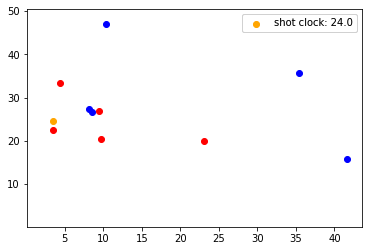

In [88]:
fig = plt.figure()
camera = Camera(fig)

for i in range(len(x_team1)):
    if i % 5 == 0:
        plt.scatter(x_ball[int(i/5)],y_ball[int(i/5)], color = 'orange')
        plt.scatter(x_team1[i:i+5], y_team1[i:i+5], color = 'blue')
        plt.scatter(x_team2[i:i+5], y_team2[i:i+5], color = 'red')
        plt.legend([f'shot clock: {shot_clock[int(i/5)]}'])
        camera.snap()
        
animation = camera.animate(interval = 50, repeat = True, repeat_delay = 500)
animation.save('celluloid_minimal_4.gif', writer = 'imagemagick')

In [ ]:
def standardize(init_list):
    standardize_list = []
    mean = sum(init_list)/len(init_list)
    stdev = np.std(init_list)
    for i in range(len(init_list)):
        standard_list.append((init_list[i] - mean)/stdev)